In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from math import isnan
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [177]:
df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv')

# df = pd.read_csv('ML_data_2021_2024.csv')

C:\Users\Misha\AppData\Local\Temp\ipykernel_15880\1109907890.py:1: DtypeWarning: Columns (4,8,14,15,24,28,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv')


In [11]:
# def set_okpo(st:str):
#     if(len(str(st)) == 7):
#         st = '0'+str(st)
#     return st

# Модель под одного поставщика

## Логика

Отбираем одного поставщика, обучаемся на его истории участий и пытаемся предсказать с какой вероятностью он победит в тендере

Для примера, давай возьмем участия ТОВ "Епіцентр К", ЕГРПОУ - 32490244

In [30]:
print(f"Количество участий Епицентра в тендерах: {len(df[df.supplier_okpo == '32490244'])}")

Количество участий Епицентра в тендерах: 26301


## Features

Фичи, которые **точно не должны попасть** в трейн датасет для обучения:
- undoc
- idlot
- cdb_number
- lot_number
- lot_status
- tender_status
- organizer_norg
- organizer_okpo
- organizer_email
- organizer_name
- supplier_norg
- supplier_okpo
- supplier_email

Может из них можно извлечь какие-то фичи, но в том виде в котором они есть изначально их нельзя добавлять в трейн датасет

### EDA

При загрузке данных, нам лучше всегда заранее определять тип данных для наших колонок, так как у нас могут быть потом проблемы с данными, искажения в данных или mixed-types

In [155]:
# Тут я выберу те, которые скорее всего могут быть проблемными
DATA_TYPES = {
    'undoc': 'int',
    'idlot': 'int',
    'lot_status': 'str',
    'payment_info': 'str',
    'cpv_code': 'str',
    'type_payment': 'str',
    'organizer_okpo': 'str',
    'supplier_okpo': 'str',
    'lot_title': 'str',
    'tender_title': 'str',
    'tender_description': 'str',
    'lot_amount': 'float',
    'lot_quantity': 'float',
    'guarantee': 'float',
    'price_offer_before_auction': 'float',
    'price_offer_after_auction': 'float'
}

DATE_COLS = ['date_publish', 'date_start_accept', 'date_end_accept',
             'date_auction', 'date_supply_from', 'date_supply_to']

# df = pd.read_csv('ML_data_2021_2024.csv')
df = pd.read_csv('D:/Диплом_СмартТендер/ML_data_2021_2024.csv', dtype=DATA_TYPES, parse_dates=DATE_COLS)

В дополнение к перечисленым выше фичам также убрал описание и название тендера, потому что с ними нет толку работать, они либо дублируют информацию из категории либо не несут информации вообще, и также сюда же вкинул цену после аукциона, поскольку этой инфы не будет до проведения тендера, а значит её не должно быть в трейне, плюс поле дисквалифицирован. 

In [120]:
clear_cols = df.columns[[0, 1, 2,3, 4,5, 6, 8, 9, 19, 25, 27, 29, 30, 33, 35, 37, 39]]
clear_cols

Index(['undoc', 'idlot', 'cbd_number', 'lot_number', 'lot_title',
       'tender_title', 'tender_description', 'lot_status', 'tender_status',
       'participation_cost', 'date_supply_from', 'organizer_norg',
       'organizer_email', 'organizer_name', 'supplier_norg', 'supplier_email',
       'price_offer_after_auction', 'disqualified'],
      dtype='object')

In [121]:
df = df.drop(clear_cols, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590491 entries, 0 to 2590490
Data columns (total 22 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   tender_procedure            object        
 1   lot_amount                  float64       
 2   tender_VAT                  int64         
 3   lot_quantity                float64       
 4   lot_measure                 object        
 5   payment_info                object        
 6   type_payment                object        
 7   guarantee                   float64       
 8   cpv_code                    object        
 9   category                    object        
 10  tender_buy_type             object        
 11  date_publish                datetime64[ns]
 12  date_start_accept           datetime64[ns]
 13  date_end_accept             datetime64[ns]
 14  date_auction                datetime64[ns]
 15  date_supply_to              object        
 16  organizer_okpo    

### Создать фичу days_to_deliver которая считает количевство дней с момента завершения подачи на тендер до для окончания поставок(date_supply_to), вместо пустых значений date_supply_to вписать среднее значение days_to deliver(ceil/floor)

Перед EDA нужно убрать участия в тех тендерах, где скрыты организатор и поставщик (с начала войны часть закупок скрывается)

Можно сбросить или по организатору или по поставщику

In [4]:
ORGANIZER_OKPO_TO_DROP = '00000000'  # Такие тендеры нас не интересуют
df = df[df['organizer_okpo'] != ORGANIZER_OKPO_TO_DROP]
df = df[df['supplier_okpo'] != ORGANIZER_OKPO_TO_DROP]

Отдельно по фичам:

- organizer_region
  
Возможно для Эпицентра такая фича не будет информативной, но в будущем для задачи предсказания победителя тендера, это будет информативная фича, так как поставщики часто хотят работать в своей области или соседней области из-за того что сумма тендера может не покрывать логистику.

Давай ниже проверим распределение поставщиков по уникальным областям (если область=null можем сбросить). Тут лучше сделать график

Посчитаем по ЕГРПОУ сколько у них уникальных областей и выведем к-ство уникальных ЕГРПОУ по к-ству областей.
То есть покажем, например, сколько участников участвовали только в одной уникальной области. Проверим ту гипотезу, которую я написал выше.

1. Для всех поставщиков и по всем участиям
2. Только для победителей (winner=1)
3. Отдельно для Епицентра (можно без графика, только цифру)

# Нет поля локация поставщика, брать самую частую из истории участий?

Все доступные кампаниии

<BarContainer object of 26 artists>

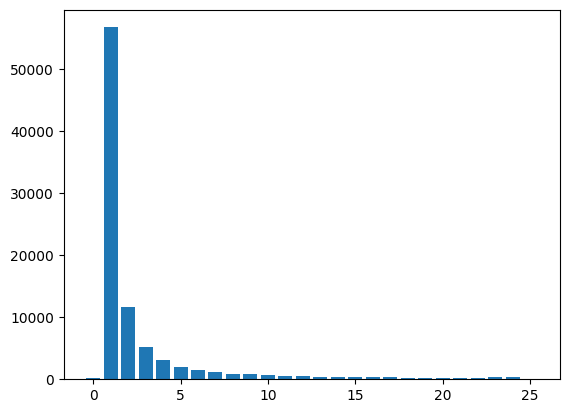

In [146]:
temp_df = df.groupby(['supplier_okpo']).nunique()
arr = list(np.unique(temp_df['organizer_region']))
vals = dict()
for i in arr:
    vals[i] = temp_df['organizer_region'][temp_df['organizer_region'] == i].count()
l = list(vals.values())
import matplotlib.pyplot as plt
plt.bar(range(0,26), l)

Только победители тендеров

<BarContainer object of 25 artists>

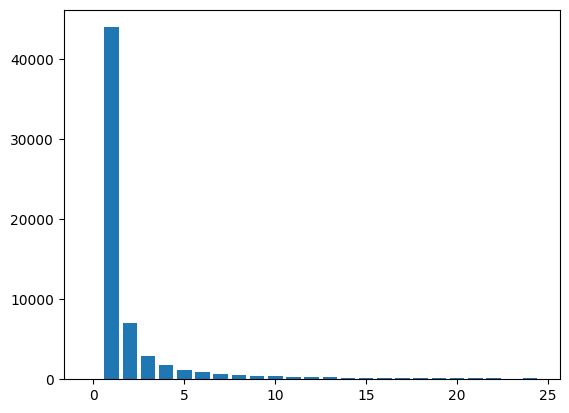

In [6]:
temp_df = df[df['winner'] == 1]
temp_df = temp_df.groupby(['supplier_okpo']).nunique()
arr = list(np.unique(temp_df['organizer_region']))
vals = dict()
for i in arr:
    vals[i] = temp_df['organizer_region'][temp_df['organizer_region'] == i].count()
l = list(vals.values())
import matplotlib.pyplot as plt
plt.bar(range(0,25), l)

In [16]:
epic_df = df[df['supplier_okpo'] == '32490244']
epic_df = epic_df.groupby(['supplier_okpo', 'organizer_region']).count()
epic_df['undoc']

supplier_okpo  organizer_region         
32490244       Івано-Франківська область     515
               Волинська область             545
               Вінницька область            1405
               Дніпропетровська область     1939
               Донецька область             1027
               Житомирська область           665
               Закарпатська область          346
               Запорізька область            962
               Київська область             9474
               Кіровоградська область        289
               Луганська область              86
               Львівська область            1418
               Миколаївська область          707
               Одеська область               675
               Полтавська область            827
               Рівненська область            694
               Сумська область               617
               Тернопільська область         277
               Харківська область            903
               Херсонська об

И еще посмотреть по категориям (но тут нужно их будет сократить до 2, 3 знака), к-ство участий по категориям, к-ство уникальных поставщиков по категориям, в разрезе всех участий, побед и только для Эпицентра

Нужно проверить нет ли у нас имбаланса по категориальным фичам

In [162]:
vals

{1: 54224,
 2: 18981,
 3: 7316,
 4: 3503,
 5: 1816,
 6: 1060,
 7: 686,
 8: 370,
 9: 266,
 10: 150,
 11: 76,
 12: 65,
 13: 34,
 14: 23,
 15: 22,
 16: 17,
 17: 7,
 18: 8,
 19: 9,
 20: 4,
 21: 5,
 22: 4,
 25: 1,
 27: 1,
 42: 1,
 46: 1}

{1: 54224, 2: 18981, 3: 7316, 4: 3503, 5: 1816, 6: 1060, 7: 686, 8: 370, 9: 266, 10: 150, 11: 76, 12: 65, 13: 34, 14: 23, 15: 22, 16: 17, 17: 7, 18: 8, 19: 9, 20: 4, 21: 5, 22: 4, 25: 1, 27: 1, 42: 1, 46: 1}


<BarContainer object of 26 artists>

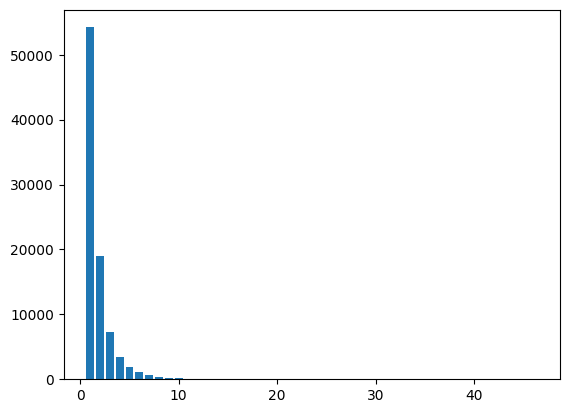

In [161]:
temp_df = df.groupby(['supplier_okpo']).nunique()
arr = list(np.unique(temp_df['category']))
vals = dict()
for i in arr:
    vals[i] = temp_df['category'][temp_df['category'] == i].count()
l = list(vals.values())
k = list(vals.keys())
print(vals)
import matplotlib.pyplot as plt
plt.bar(k, l)

{1: 120843, 2: 24514, 3: 7931, 4: 3005, 5: 1175, 6: 684, 7: 753, 8: 130, 9: 35, 10: 1}


<BarContainer object of 10 artists>

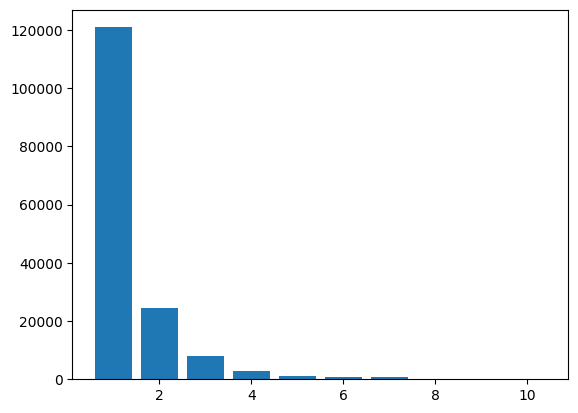

In [163]:
temp_df = df.groupby(['supplier_okpo', 'category']).nunique()
arr = list(np.unique(temp_df['sub_category']))
vals = dict()
for i in arr:
    vals[i] = temp_df['sub_category'][temp_df['sub_category'] == i].count()
l = list(vals.values())
k = list(vals.keys())
print(vals)
import matplotlib.pyplot as plt
plt.bar(k, l)

In [166]:
df['category']

0          34
1          34
2          34
3           9
4           9
           ..
2590486    33
2590487    33
2590488    33
2590489     9
2590490     9
Name: category, Length: 2590490, dtype: int64

{1: 179284, 2: 28658, 3: 7537, 4: 2989, 5: 1110, 6: 478, 7: 276, 8: 136, 9: 84, 10: 11}


<BarContainer object of 10 artists>

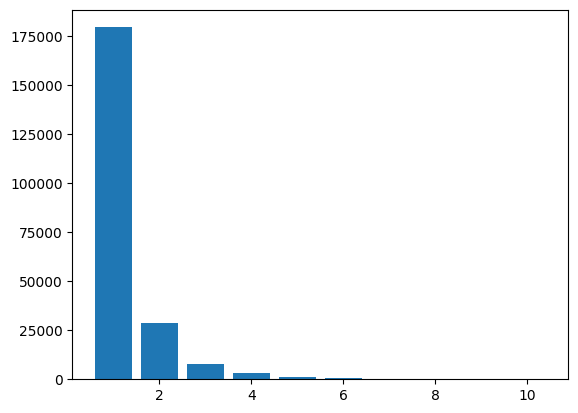

In [25]:
temp_df = df.groupby(['supplier_okpo', 'category', 'sub_category']).nunique()
arr = list(np.unique(temp_df['subsub_category']))
vals = dict()
for i in arr:
    vals[i] = temp_df['subsub_category'][temp_df['subsub_category'] == i].count()
l = list(vals.values())
k = list(vals.keys())
print(vals)
import matplotlib.pyplot as plt
plt.bar(k, l)

Encoding Categorical Features

Давай напишем функции для разных типов кодирования категориальных фич (на примере Епицентра будем тестировать насколько это будет влиять на итоговый результат)

- Label Encoding
- One-Hot Encoding
- Dummy Encoding
- Effect Encoding (тут нужно подумать, подойдет ли этот метод для какой-то из фич, возможно его не нужно будет делать)

В функцию мы должны передавать или dataframe или колонку или список колонок, которые мы хотим перекодировать для модели.
Если хочешь, можешь сделать отдельный класс для Encoding и собрать там все методы, но это не обязательно.

In [92]:
def label_encoding(dataframe, col_name):
    values = set(dataframe[col_name])
    


def one_hot(dataframe, col_name):
    one_hot_encoded = pd.get_dummies(dataframe[col_name], prefix=col_name)
    dataframe = pd.concat([dataframe, one_hot_encoded], axis=1)
    return dataframe

Scaling Features

Так же и для int, float фич, возможно, нужна нормализация/стандартизация данных

- StandardScaler
- MinMax
- MaxAbs
- RobustScaler

In [ ]:
# CODE

NaN handling

По фичам, которые у нас могут быть NaN, тоже нужно продумать логику, как их обрабатывать
В sklearn есть отдельный модуль Impute, посмотри есть ли там какие-то методы, которые могут помочь нам не урезать наш набор данных и не сбрасывать NaN или создавать под NaN отдельную категорию


In [37]:
epic_df.isnull().sum()

tender_procedure                  0
lot_amount                        0
tender_VAT                        0
lot_quantity                      0
lot_measure                       0
payment_info                   5456
type_payment                   5456
guarantee                     26468
cpv_code                          0
category                          0
participation_cost             5348
tender_buy_type               10202
date_publish                      0
date_start_accept                 0
date_end_accept                   0
date_auction                   7007
date_supply_to                   75
organizer_okpo                    0
organizer_region                 91
organizer_city                  300
supplier_okpo                     0
price_offer_before_auction        0
winner                            0
dtype: int64

In [177]:
df['payment_info'].str.extract('(\d+)').payment_info.unique()

AttributeError: 'DataFrame' object has no attribute 'payment_info'

In [79]:
c_epic_df = epic_df.reset_index()
days_to_deliver = []
c_epic_df['date_supply_to'][2660] = '2021-04-30 01:00:00.000'
c_epic_df['date_supply_to'][2661] = '2021-04-30 01:00:00.000'
for i in range(c_epic_df.shape[0]):
    if(c_epic_df['date_supply_to'].notna()[i]):
        days_to_deliver.append((pd.to_datetime(c_epic_df['date_supply_to'][i])-c_epic_df['date_end_accept'][i]).days)
    else:
        days_to_deliver.append(90)

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\1485879639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2660] = '2021-04-30 01:00:00.000'
C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\1485879639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2661] = '2021-04-30 01:00:00.000'


In [81]:
epic_df['days_to_deliver']

788        349
794        349
3250       106
3255       106
3334       345
          ... 
2590287    191
2590464    345
2590465    345
2590475    345
2590477    345
Name: days_to_deliver, Length: 26954, dtype: int64

Переделать фичу Категория

Как можно разложить фичу категории

Берем только первые 8 цифр, из них:

Первые две - направление (строительство, медицина, продукты питания и т.д.)

Все что ниже уже характеризирует конкретное направление.

Примеры:
09310000-5 Електрична енергія

Если мы возьмем и разложим данную категорию

09000000-3 Нафтопродукти, паливо, електроенергія та інші джерела енергії -> 09300000-2 Електрична, теплова, сонячна та атомна енергія ->
09310000-5 Електрична енергія

Категорию можно разложить после второго, третьего, четвертого и до пятого знака, пока не встретится в ней число 0

Но на практике дальше 4 четвертого знака заходить уже нет смысла. По этому второй/третий я бы брал. Возможно придумать какую-то особенную фичу


Была 1 запись с cpv_code равным 91, её выкинул

In [149]:
np.unique(df['cpv_code'].str.slice(0,2))

array(['03', '09', '14', '15', '16', '18', '19', '22', '24', '30', '31',
       '32', '33', '34', '35', '37', '38', '39', '41', '42', '43', '44',
       '45', '48', '50', '51', '55', '60', '63', '64', '65', '66', '70',
       '71', '72', '73', '75', '76', '77', '79', '80', '85', '90', '91',
       '92', '98', '99'], dtype=object)

In [156]:
df = df[df['cpv_code'] != '91']

In [158]:
categories, sub_categories, subsub_categories = [],[],[]
for i in df['cpv_code']:
    categories.append(int((i)[:2]))
    sub_categories.append(int((i)[2]))
    subsub_categories.append(int((i)[3]))
df['category'] = categories
df['sub_category'] = sub_categories
df['subsub_category'] = subsub_categories

In [160]:
set(categories)

{3,
 9,
 14,
 15,
 16,
 18,
 19,
 22,
 24,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 48,
 50,
 51,
 55,
 60,
 63,
 64,
 65,
 66,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 79,
 80,
 85,
 90,
 92,
 98,
 99}

Гарантия как категориальная фича ???

Проверить гипотезу, что гарантию лучше использовать как категориальную фичу

Если сумма заполнена = есть гарантия

In [51]:
guarantees = [False if (isnan(x) or int(x) == 0) else True for x in df['guarantee']]
df['guarantee'] = guarantees

Посмотреть итоговую корреляцию фичей. Фичи у которых сильная корелляция - дропнуть

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\1582721150.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(epic_df.corr())


<Axes: >

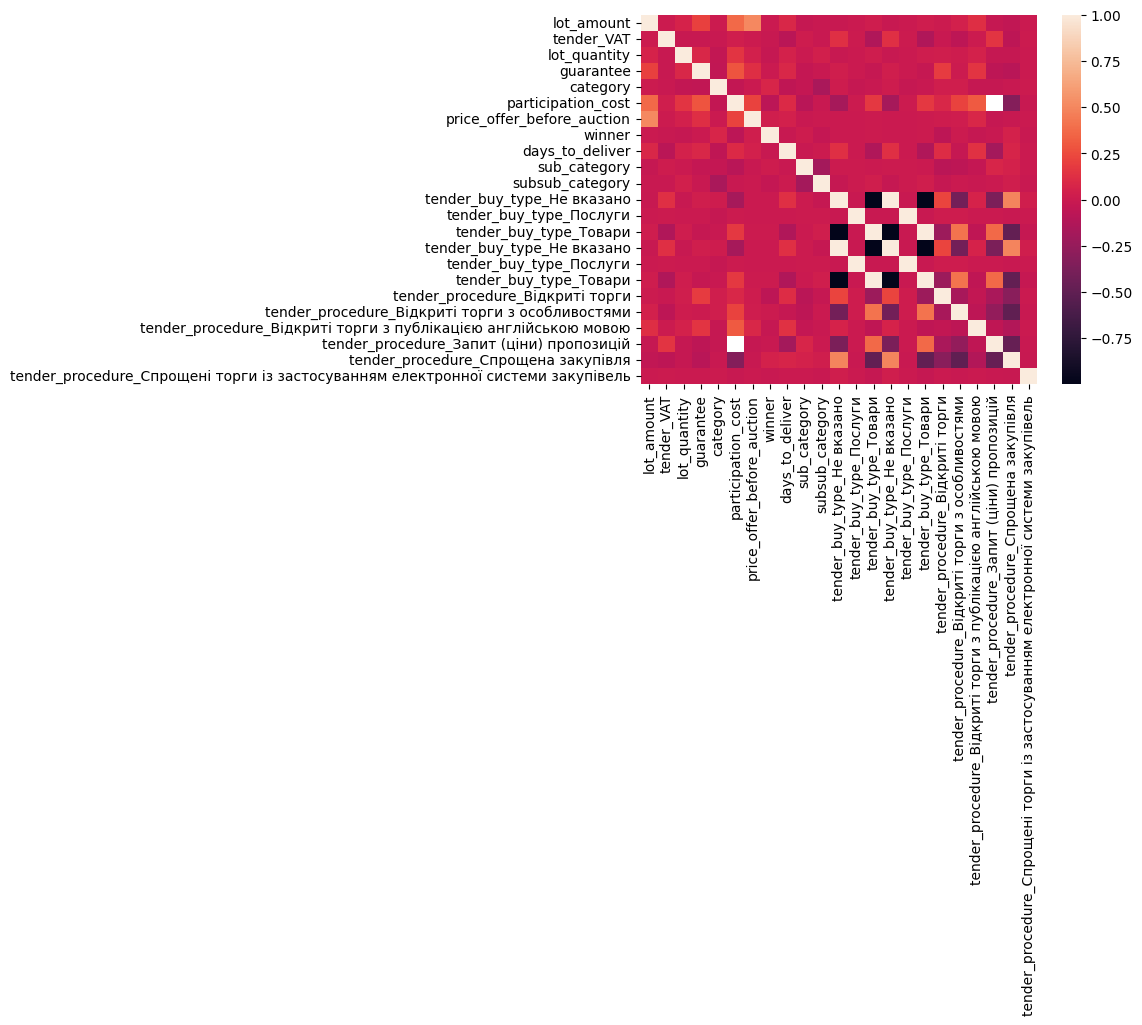

In [108]:
import seaborn as sns
sns.heatmap(epic_df.corr())

Реализовать кастомный train_test_split или KFold.

Логика в том что, мы не можем просто рандомно отбирать данные для обучения и валидации, так как модель должна обучаться на данных отсортированных по дате.

Условно - обучаемся на 2021, 2022 и 3 месяцах 2023 года, остальные 9 месяцев 2023 года для валидации.

In [122]:
epic_df = df[df['supplier_okpo']=='32490244']
# epic_df_train = epic_df[epic_df['date_publish'] < pd.to_datetime('2023-02-28')]
# epic_df_test = epic_df[epic_df['date_publish'] >= pd.to_datetime('2023-02-28')]

Добавление фичи с днями на доставку, NaN заменяю заранее расчитаным средним значеннием 

In [123]:
c_epic_df = epic_df.reset_index()
days_to_deliver = []
c_epic_df['date_supply_to'][2660] = '2021-04-30 01:00:00.000'
c_epic_df['date_supply_to'][2661] = '2021-04-30 01:00:00.000'
for i in range(c_epic_df.shape[0]):
    
    if(c_epic_df['date_supply_to'].notna()[i]):
        days_to_deliver.append((pd.to_datetime(c_epic_df['date_supply_to'][i])-c_epic_df['date_end_accept'][i]).days)
    else:
        days_to_deliver.append(90)
epic_df['days_to_deliver'] = days_to_deliver

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\3485201746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2660] = '2021-04-30 01:00:00.000'
C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\3485201746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_epic_df['date_supply_to'][2661] = '2021-04-30 01:00:00.000'
C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\3485201746.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Обрабатываю поле cpv_code, создаю 3 новых фичи вместо него

In [150]:
categories, sub_categories, subsub_categories = [],[],[]
for i in epic_df['cpv_code']:
    categories.append(int((i)[:2]))
    sub_categories.append(int((i)[2]))
    subsub_categories.append(int((i)[3]))
epic_df['category'] = categories
epic_df['sub_category'] = sub_categories
epic_df['subsub_category'] = subsub_categories

KeyError: 'cpv_code'

In [125]:
guarantees = [False if (isnan(x) or int(x) == 0) else True for x in epic_df['guarantee']]
epic_df['guarantee'] = guarantees

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\983640462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['guarantee'] = guarantees


Для поля tender_buy_type в котором содержится 10000 пустых записей, а информативность оно все таки несет, то я не вижу другого выхода как создать доп категорию для NaN, и применить one-hot encoding

In [98]:
epic_df.drop(['tender_buy_type_Не вказано', 'tender_buy_type_Послуги', 'tender_buy_type_Товари'],axis=1)

,tender_procedure,lot_amount,tender_VAT,lot_quantity,lot_measure,payment_info,type_payment,guarantee,cpv_code,category,...,date_supply_to,organizer_okpo,organizer_region,organizer_city,supplier_okpo,price_offer_before_auction,winner,days_to_deliver,sub_category,subsub_category
788,Спрощена закупівля,3000000.0,1,5800.0,м³,90 Календарних днів\r,Пiсляоплата 100.0%\r,False,14210000-6,14,...,2021-12-31 00:00:00.000,03349022,Львівська область,Львів,32490244,0.0,0,349,2,1
794,Спрощена закупівля,3000000.0,1,5800.0,м³,90 Календарних днів\r,Пiсляоплата 100.0%\r,False,14210000-6,14,...,2021-12-31 00:00:00.000,03349022,Львівська область,Львів,32490244,2994774.0,0,349,2,1
3250,Спрощена закупівля,98690.0,0,1950.0,шт,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-05-01 00:00:00.000,14310052,Харківська область,Харків,32490244,0.0,0,106,1,1
3255,Спрощена закупівля,98690.0,0,1950.0,шт,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-05-01 00:00:00.000,14310052,Харківська область,Харків,32490244,72000.0,1,106,1,1
3334,Відкриті торги,146000.0,1,1.0,лот,30 Календарних днів\r,Пiсляоплата 100.0%\r,False,44110000-4,44,...,2021-12-31 15:56:49.000,03327121,Запорізька область,ЗАПОРІЖЖЯ,32490244,104640.0,0,345,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590287,Запит (ціни) пропозицій,2248.0,1,2.0,шт,NaN,NaN,False,39710000-2,39,...,2024-07-31 15:49:13.000,03357168,Черкаська область,Черкаси,32490244,0.0,1,191,7,1
2590464,Запит (ціни) пропозицій,1800.0,1,3.6,м²,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,1,345,1,1
2590465,Запит (ціни) пропозицій,1800.0,1,3.6,м²,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,0,345,1,1
2590475,Запит (ціни) пропозицій,3500.0,1,250.0,кг,NaN,NaN,False,44110000-4,44,...,2024-12-31 00:00:00.000,02071100,Полтавська область,Полтава,32490244,0.0,0,345,1,1


In [126]:
epic_df['tender_buy_type']=epic_df['tender_buy_type'].fillna('Не вказано')
epic_df = one_hot(epic_df, 'tender_buy_type')
epic_df = one_hot(epic_df, 'tender_procedure')

C:\Users\Misha\AppData\Local\Temp\ipykernel_6356\2005132578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epic_df['tender_buy_type']=epic_df['tender_buy_type'].fillna('Не вказано')


In [130]:
epic_df = epic_df.drop(['tender_buy_type', 'cpv_code', 'tender_procedure', 'date_supply_to', 'supplier_okpo', 'lot_measure', 'payment_info', 'type_payment', 'organizer_city', 'organizer_region', 'organizer_okpo'], axis=1)

In [131]:
epic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26954 entries, 788 to 2590477
Data columns (total 23 columns):
 #   Column                                                                           Non-Null Count  Dtype         
---  ------                                                                           --------------  -----         
 0   lot_amount                                                                       26954 non-null  float64       
 1   tender_VAT                                                                       26954 non-null  int64         
 2   lot_quantity                                                                     26954 non-null  float64       
 3   guarantee                                                                        26954 non-null  bool          
 4   category                                                                         26954 non-null  int64         
 5   date_publish                                                   

In [132]:
epic_df_train = epic_df[epic_df['date_publish'] < pd.to_datetime('2023-02-28')]
epic_df_test = epic_df[epic_df['date_publish'] >= pd.to_datetime('2023-02-28')]

In [133]:
y_train = epic_df_train['winner']
X_train = epic_df_train.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish','winner'], axis=1)
y_test = epic_df_test['winner']
X_test = epic_df_test.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish','winner'], axis=1)

Инициализация моделей:

Модели, которые можно применить и которые считаются наиболее эффективными в таких задачах:

- XGBoost
- LightGBM
- Neural Network (Keras, TensorFlow, PyTorch)
- Ensemble models (XGBoost + LightGBM)

В scikit-learn тоже есть еще какие-то модели, если захочешь можешь и оттуда взять еще какие-то, по типу KNN, SVM и другие

Подбор гиперпараметров к моделям:

Модуль - hyperopt или другой какой-то

Для scikit-learn - GridSearchCV и вроде RandomGridSearchCV

Для моделей нужно будет подобрать правильные гиперпараметры.


In [111]:
epic_df = epic_df.drop(['date_start_accept', 'date_end_accept', 'date_auction', 'date_publish'], axis=1)

In [139]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score

def xgb_objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        objective='binary:logistic',
        eval_metric='logloss'
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = -roc_auc_score(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

# Define hyperparameter search space for XGBoost
xgb_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 1)
}

# Define objective function for LightGBM
def lgb_objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        objective='binary',
        metric='binary_logloss'
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = -roc_auc_score(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

lgb_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1)
}

xgb_trials = Trials()
lgb_trials = Trials()

# Optimize XGBoost hyperparameters
xgb_best = fmin(fn=xgb_objective, space=xgb_space, algo=tpe.suggest, max_evals=50, trials=xgb_trials, verbose=False)

# Optimize LightGBM hyperparameters
lgb_best = fmin(fn=lgb_objective, space=lgb_space, algo=tpe.suggest, max_evals=50, trials=lgb_trials, verbose=False)

# Print the best hyperparameters for XGBoost and LightGBM
print("Best XGBoost hyperparameters:", xgb_best)
print("Best LightGBM hyperparameters:", lgb_best)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start tra

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] Accuracy may be 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] Accuracy may be 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] Accuracy may be 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] Accuracy may be 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be 

Best XGBoost hyperparameters: {'colsample_bytree': 0.6151588303315247, 'gamma': 0.5397037800644142, 'learning_rate': 0.866754921615864, 'max_depth': 3.0, 'n_estimators': 257.0, 'subsample': 0.8402915188610319}<br>
Best LightGBM hyperparameters: {'colsample_bytree': 0.5570200026503596, 'learning_rate': 0.9653346619512946, 'max_depth': 11.0, 'n_estimators': 128.0, 'reg_alpha': 0.7829645498395199, 'subsample': 0.9981307296781777}

In [145]:
xgc = XGBClassifier(n_estimators=257,
        max_depth=3,
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        objective='binary:logistic',
        eval_metric='logloss')
lbg = LGBMClassifier(n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        objective='binary',
        metric='binary_logloss')

In [140]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
roc = roc_auc_score(preds, y_test)
print(roc)
for i in range(len(xgc.feature_names_in_)):
    print(xgc.feature_names_in_[i],' : ',xgc.feature_importances_[i])

0.5983850382738022
lot_amount  :  0.030370591
tender_VAT  :  0.026982132
lot_quantity  :  0.028561816
guarantee  :  0.015285417
category  :  0.041274473
price_offer_before_auction  :  0.12649307
days_to_deliver  :  0.027353734
sub_category  :  0.032905456
subsub_category  :  0.03415965
tender_buy_type_Не вказано  :  0.028951934
tender_buy_type_Послуги  :  0.0
tender_buy_type_Товари  :  0.34522623
tender_procedure_Відкриті торги  :  0.08461187
tender_procedure_Відкриті торги з особливостями  :  0.039142665
tender_procedure_Відкриті торги з публікацією англійською мовою  :  0.035742097
tender_procedure_Запит (ціни) пропозицій  :  0.03476604
tender_procedure_Спрощена закупівля  :  0.06817284
tender_procedure_Спрощені торги із застосуванням електронної системи закупівель  :  0.0


In [144]:
lbg.fit(X_train, y_train)
preds = lbg.predict(X_test)
roc = roc_auc_score(preds, y_test)
print(roc)
for i in range(len(lbg.feature_name_)):
    print(lbg.feature_name_[i],' : ',lbg.feature_importances_[i])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3504, number of negative: 14328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196501 -> initscore=-1.408310
[LightGBM] [Info] Start training from score -1.408310
0.6439879034342528
lot_amount  :  526
tender_VAT  :  35
lot_quantity  :  494
guarantee  :  7
category  :  226
price_offer_before_auction  :  370
days_to_deliver  :  625
sub_category  :  253
subsub_category  :  185
tender_buy_type_Не_вказано  :  48
tender_buy_type_Послуги  :  0
tender_buy_type_Товари  :  23
tender_procedure_Відкриті_торги  :  82
tender_procedure

<Axes: >

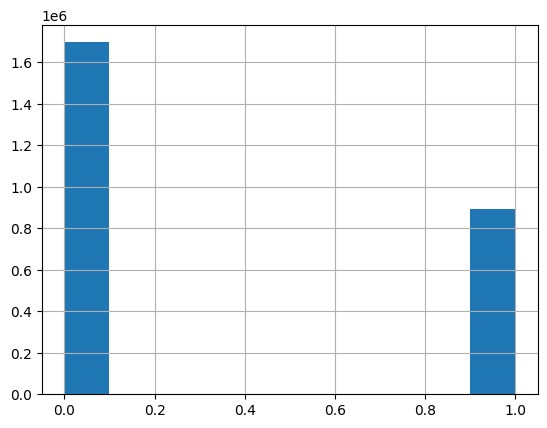

In [180]:
df['winner'].hist()

Анализ результатов

Нужно добавить метрики, по которым ты будешь оценивать эффективность той или иной модели

- Accuracy
- ROC AUC Score
- Confusion matrix
- Precision
- Recall
- Precision-Recall curve
- F1 score
- Log loss

Все модели, их параметры и результаты метрик сохраняй себе в каком-то виде.

Так же не забывай отслеживать сколько какая модель затрачивает времени на обучение/поиск гиперпараметров

Такую инфо можно сохранять используя dict, после этого сохранять в json.

Пример:

```Python
model_states = {
    "my_model_name_30_01_2024.pth": {
        "model": "XGBoost",
        "learning_time_sec": 900,
        "hyperparams": {
            "params1": 1,
            "params2": 2,
            "params3": 3
        },
        "scores": {
            "roc_auc": 0.5,
            "f1": 0.6,
            "accuracy": 0.7
        },
        "data": {
            "columns": ["col1", "col2", "col3"],
            "target": ["col4"]
        }
    },
    
    "my_model_version2_30_01_2024.pth": {}
}
```